In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

random_seed = 42
torch.manual_seed(random_seed)

In [4]:
import torchvision
from torchinfo import summary

# Download pretrained ViT weights and model
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_base_12 = torchvision.models.vit_b_16(weights=vit_weights)

# # Print a summary
# summary(model=vit_base_12, 
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [6]:
vit_transforms = vit_weights.transforms()

data_dir = '../EuroSAT/2750'
eurosat_dataset = datasets.ImageFolder(data_dir, transform=vit_transforms)
eurosat_dataset
# Split the data into train and test sets while preserving the original split

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ../EuroSAT/2750
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [7]:
from torch.utils.data import DataLoader, random_split

#split into 80,10,10
total_size = len(eurosat_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoader instances for train, validation, and test sets
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*1, shuffle=False)

In [12]:
# Define the ResNet-18 model
class EuroSAT_ViTBase12(nn.Module):
    def __init__(self):
        super(EuroSAT_ViTBase12, self).__init__()
        self.eurosat = vit_base_12  # Initialize ResNet-18 without pretrained weights
        self.eurosat.heads = nn.Linear(768, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.eurosat(x)


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## ***Fine-Tune only Last Layer:***

In [82]:
model_last_layer_FT = EuroSAT_ViTBase12()
model_last_layer_FT.load_state_dict(torch.load("eurosat-vit-base12-last-layer-tune.pth"))
model_last_layer_FT

EuroSAT_ViTBase12(
  (eurosat): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

In [83]:
model_last_layer_FT = model_last_layer_FT.to(device)
criterion = nn.CrossEntropyLoss()

In [11]:
eurosat_dataset.class_to_idx

{'AnnualCrop': 0,
 'Forest': 1,
 'HerbaceousVegetation': 2,
 'Highway': 3,
 'Industrial': 4,
 'Pasture': 5,
 'PermanentCrop': 6,
 'Residential': 7,
 'River': 8,
 'SeaLake': 9}

In [27]:
# take any image from the test_loader?
# or take any image of the train dataset
#Let's take one image from the each class and show the feature attention map..

correct_test = 0
total_test = 0
test_loss = 0.0

correct_predict_Last_Layer_FT = []
wrong_predict_Last_Layer_FT = []


index = 0
with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_last_layer_FT(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            if predicted==labels:
                correct_predict_Last_Layer_FT.append(index)
            else:
                wrong_predict_Last_Layer_FT.append(index)
            index+=1

avg_loss_test = test_loss / len(test_loader)
accuracy_test = 100 * correct_test / total_test
print("Performance of model by Fine-tuning Only Last Layer:")
print("Test accuracy: ",accuracy_test,"%", " Test Loss: ",avg_loss_test)

performance of model by Fine-tuning Only Last Layer:
Test accuracy:  95.96296296296296 %  Test Loss:  0.1167210676710381


In [40]:
#Convert test loader to list with image and labels...
test_data_list = []

for images, labels in test_loader:
    test_data_list.extend([(image, label) for image, label in zip(images, labels)])

In [41]:
test_data_list[0]

(tensor([[[-0.0287, -0.0116, -0.0287,  ..., -1.1075, -1.0562, -0.9534],
          [-0.1486, -0.1486, -0.1486,  ..., -1.1075, -1.0562, -0.9534],
          [-0.2513, -0.2513, -0.2513,  ..., -1.1075, -1.0562, -0.9534],
          ...,
          [-0.6281, -0.5424, -0.5082,  ..., -1.0219, -1.0219, -1.0048],
          [-0.6281, -0.5596, -0.5424,  ..., -1.0219, -1.0219, -1.0048],
          [-0.5938, -0.5596, -0.5596,  ..., -1.0390, -1.0390, -1.0219]],
 
         [[-0.2500, -0.2325, -0.2325,  ..., -0.6877, -0.6527, -0.5826],
          [-0.3025, -0.2850, -0.2850,  ..., -0.6877, -0.6352, -0.5651],
          [-0.3200, -0.3200, -0.3200,  ..., -0.6877, -0.6527, -0.5826],
          ...,
          [-0.3901, -0.3200, -0.3025,  ..., -0.6001, -0.6001, -0.5826],
          [-0.4076, -0.3375, -0.3375,  ..., -0.6001, -0.6001, -0.5826],
          [-0.3901, -0.3550, -0.3725,  ..., -0.6176, -0.6176, -0.6001]],
 
         [[ 0.1128,  0.1128,  0.1128,  ..., -0.2010, -0.1487, -0.0790],
          [ 0.0779,  0.0779,

In [42]:
def transform(img, img_size):
    img = transforms.Resize(img_size)(img)
    img = transforms.ToTensor()(img)
    return img


def visualize_predict(model, img, img_size, patch_size, device):
    img_pre = transform(img, img_size)
    attention = visualize_attention(model, img_pre, patch_size, device)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.get_last_selfattention(img.to(device))

    nh = attentions.shape[1]  # number of head

    # keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0]

    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()



class Loader(object):
    def __init__(self):
        self.uploader = widgets.FileUpload(accept='image/*', multiple=False)
        self._start()

    def _start(self):
        display(self.uploader)

    def getLastImage(self):
        try:
            for uploaded_filename in self.uploader.value:
                uploaded_filename = uploaded_filename
            img = Image.open(io.BytesIO(
                bytes(self.uploader.value[uploaded_filename]['content'])))

            return img
        except:
            return None

    def saveImage(self, path):
        with open(path, 'wb') as output_file:
            for uploaded_filename in self.uploader.value:
                content = self.uploader.value[uploaded_filename]['content']
                output_file.write(content)

In [43]:

visualize_predict(model, img, img_size, patch_size, device)

NameError: name 'img' is not defined

In [56]:
def visualize_attention_maps(model, image_tensor, layer_num):
    # Set the model to evaluation mode
    model.eval()

    # Forward pass to get the attention maps
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        image_tensor = image_tensor.unsqueeze(0)
        print(image_tensor.shape)
        print(model(image_tensor))
        outputs = model(image_tensor)

        attention_maps = outputs['attention_probs'][layer_num]

    # Reshape attention maps for visualization (assuming a single image)
    attention_maps = attention_maps.squeeze(0)

    # Create a grid of attention maps
    attention_map_grid = torch.nn.functional.interpolate(
        attention_maps.unsqueeze(0), scale_factor=4, mode='bilinear', align_corners=False)

    # Normalize the attention map values to [0, 1]
    attention_map_grid = (attention_map_grid - attention_map_grid.min()) / (
        attention_map_grid.max() - attention_map_grid.min())

    return attention_map_grid


In [57]:
# Replace these with your image and label tensors
image_tensor =  test_data_list[0][0] # Example image tensor
label_tensor =  test_data_list[0][1] # Example label tensor
layer_num = 6

attention_map_grid = visualize_attention_maps(model_last_layer_FT, image_tensor, layer_num)

# Convert the attention map grid to a NumPy array for visualization
attention_map_grid_np = attention_map_grid.cpu().numpy()

# Display the attention maps
plt.imshow(attention_map_grid_np[0], cmap='viridis')
plt.title(f'Attention Map for Layer {layer_num}')
plt.axis('off')
plt.show()


torch.Size([1, 3, 224, 224])
tensor([[-5.5143, -2.6638,  3.0349, -4.1036, -7.7980, -4.0665,  0.8132,  8.3641,
         -3.7741, -4.9718]], device='cuda:0')


IndexError: too many indices for tensor of dimension 2

In [75]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt


image_tensor =  test_data_list[0][0] # Example image tensor
label_tensor =  test_data_list[0][1] # Example label tensor

image_tensor = image_tensor.to(device)
image_tensor = image_tensor.unsqueeze(0)

# Initialize a list to store feature maps
feature_maps = []


# Register a forward hook to capture attention maps
def hook(module, input, output):
    feature_maps.append(output)

# Assuming the ViT model architecture has layers named 'eurosat.encoder.layers'
print(len(model_last_layer_FT.eurosat.encoder.layers))

for block in model_last_layer_FT.eurosat.encoder.layers:
    # print(block)
    block.self_attention.register_forward_hook(hook)

with torch.no_grad():
    model_last_layer_FT(image_tensor)  # Add batch dimension

# Load and preprocess your image_tensor as before
# Forward pass to get model outputs and capture attention maps
# outputs = model_last_layer_FT(image_tensor)

print(len(feature_maps))

# Visualize attention maps for all transformer layers
for layer_num, attention_map in enumerate(feature_maps):
    attention_map = attention_map.mean(dim=1, keepdim=True)  # Calculate the mean across attention heads
    attention_map = torch.nn.functional.interpolate(
        attention_map, scale_factor=32, mode='bilinear', align_corners=False)
    attention_map = attention_map.squeeze(0).cpu().numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(attention_map, cmap='viridis')
    plt.title(f'Attention Map for Layer {layer_num + 1}')
    plt.axis('off')
    plt.show()


12
108


AttributeError: 'tuple' object has no attribute 'mean'

In [65]:
for layer in model.modules():
    print(layer)

EuroSAT_ViTBase12(
  (eurosat): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


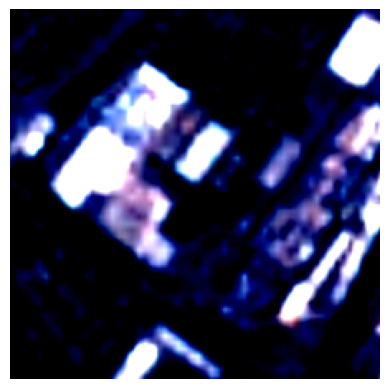

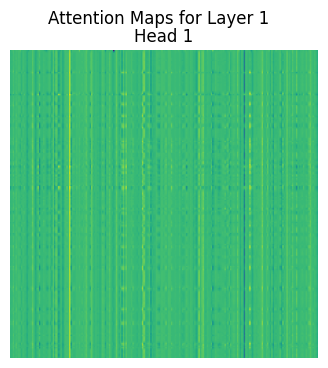

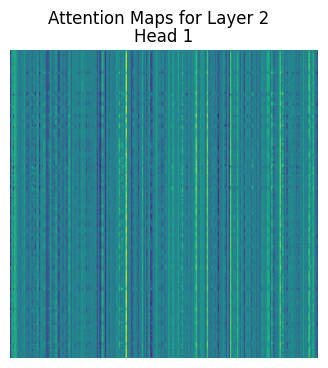

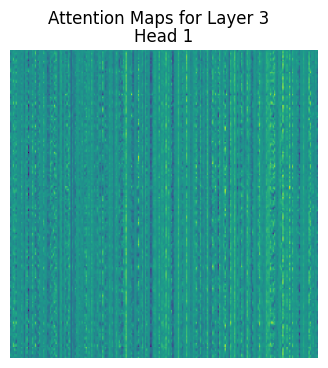

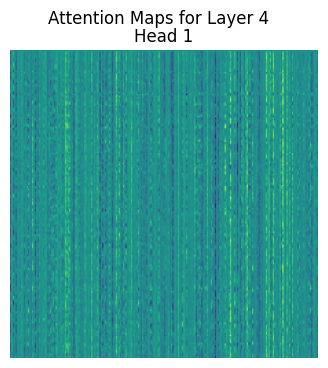

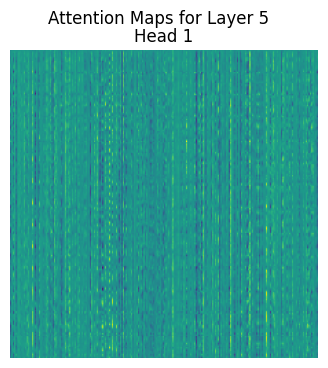

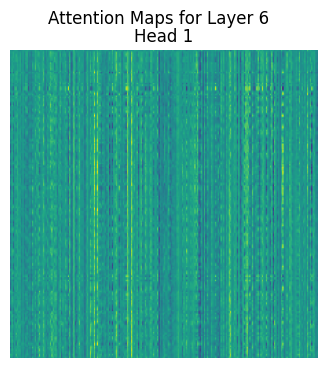

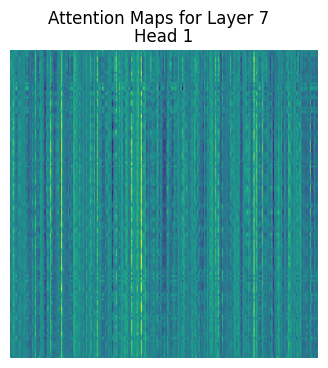

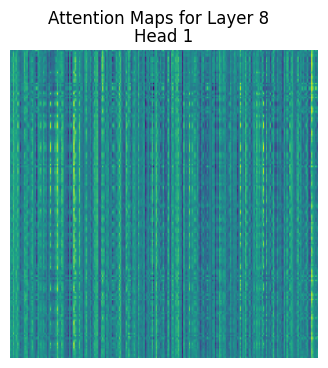

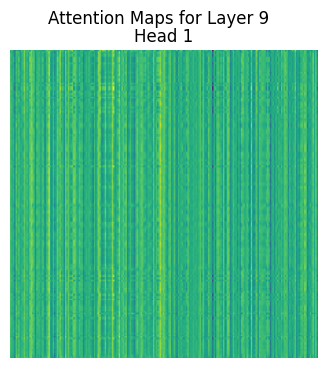

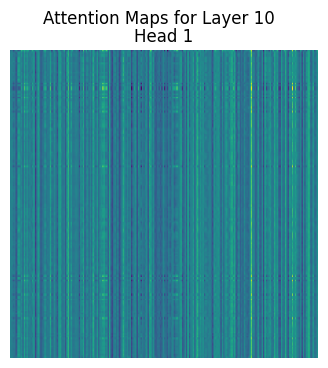

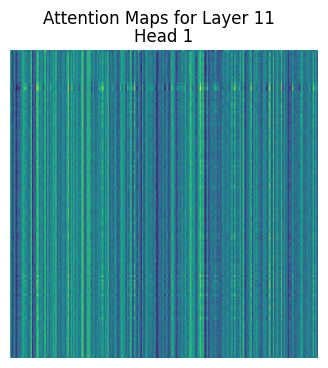

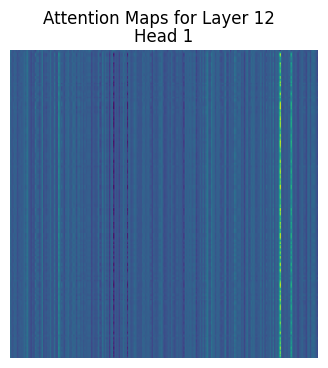

In [107]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your image_tensor

image_tensor =  test_data_list[12][0] # Example image tensor
label_tensor =  test_data_list[12][1] # Example label tensor

image_tensor = image_tensor.to(device)
image_tensor = image_tensor.unsqueeze(0)

class ViTWithAttention(nn.Module):
    def __init__(self, vit_model):
        super(ViTWithAttention, self).__init__()
        self.vit = vit_model
        self.attention_maps = []  # Initialize a list to store attention maps

        # Register a forward hook to capture attention maps
        def hook(module, input, output):
            self.attention_maps.append(output)

        # Assuming the ViT model architecture has layers named 'eurosat.encoder.layers'
        for block in self.vit.eurosat.encoder.layers:
            block.self_attention.register_forward_hook(hook)

    def forward(self, x):
        # Clear the list of attention maps before each forward pass
        self.attention_maps = []

        outputs = self.vit(x)
        return outputs

# Instantiate the modified ViT model
model = ViTWithAttention(model_last_layer_FT)

# Forward pass to get model outputs and capture attention maps
with torch.no_grad():
    outputs = model(image_tensor)
    

image_numpy = image_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Display the image using Matplotlib
plt.imshow(image_numpy)
plt.axis('off')  # Turn off axis labels
plt.show()

# Visualize attention maps for all transformer layers
for layer_num, attention_map_tuple in enumerate(model.attention_maps):
    attention_map = attention_map_tuple[0]  # Access the first element of the tuple

    # Reshape the attention map to match the dimensions of the input image
    attention_map = torch.nn.functional.interpolate(
        attention_map.unsqueeze(0), size=image_tensor.shape[-2:], mode='bilinear', align_corners=False)
    attention_map = attention_map.squeeze(0).cpu().numpy()

    num_heads, _, _ = attention_map.shape

    # Determine the number of columns dynamically based on the number of attention heads
    num_cols = min(4, num_heads)  # Display up to 4 heads per row
    num_rows = (num_heads + num_cols - 1) // num_cols

    # Create a grid of subplots for each attention head
    plt.figure(figsize=(4, 4))
    for i in range(num_heads):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(attention_map[i], cmap='viridis')
        plt.title(f'Head {i + 1}')
        plt.axis('off')

    plt.suptitle(f'Attention Maps for Layer {layer_num + 1}')
    plt.show()

In [100]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Assuming you have already loaded and preprocessed your image_tensor
# Define your ViT model (your_eurosat_vit_model) here

# Define a function to visualize attention maps for all transformer layers
def visualize_attention_maps(model, img, patch_size, device):
    attentions = visualize_attention(model, img, patch_size, device)
    
    # Visualize attention maps for all transformer layers
    for layer_num, attention_map in enumerate(attentions):
        plot_attention(img, attention_map, layer_num)

# Define a function to visualize attention maps for a specific layer
def visualize_attention(model, img, patch_size, device):
    # Make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    # Get attention maps for the last self-attention layer (adjust this based on your model)
    attentions = model.eurosat.encoder.layers[-1].self_attention(img.to(device))

    nh = attentions.shape[1]  # Number of attention heads

    # Keep only the output patch attention
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

    return attentions

# Define a function to plot attention maps
def plot_attention(img, attention_map, layer_num):
    n_heads = attention_map.shape[0]

    plt.figure(figsize=(12, 12))
    text = ["Original Image", "Layer Mean Attention"]
    
    # Convert the image tensor to a NumPy ndarray and permute the dimensions
    img = img.permute(1, 2, 0).cpu().numpy()
    
    # Plot the original image
    plt.subplot(1, n_heads + 1, 1)
    plt.imshow(img, cmap='viridis')
    plt.title(text[0])
    
    # Plot the mean attention map for the layer
    plt.subplot(1, n_heads + 1, 2)
    plt.imshow(np.mean(attention_map, 0), cmap='viridis')
    plt.title(text[1])
    
    # Plot attention maps for each head
    for i in range(n_heads):
        plt.subplot(1, n_heads + 1, i + 3)
        plt.imshow(attention_map[i], cmap='viridis')
        plt.title(f"Head {i + 1}")
    
    plt.suptitle(f'Attention Maps for Layer {layer_num + 1}')
    plt.show()

# Visualize attention maps for all layers
visualize_attention_maps(model_last_layer_FT, image_tensor, patch_size=16, device='cuda')


TypeError: MultiheadAttention.forward() missing 2 required positional arguments: 'key' and 'value'

In [106]:
import torch
import matplotlib.pyplot as plt

# Assuming 'model' is your fine-tuned Vision Transformer model
# and 'image_tensor' is the input image in tensor form

# Put the model in evaluation mode
model_last_layer_FT.eval()

# Forward pass to get the model's output and intermediate representations
with torch.no_grad():
    output = model_last_layer_FT(image_tensor)

# Extract attention maps from the model's encoder layers
attention_maps = []

# Assuming 'model' has a structure similar to the provided model
for layer in model_last_layer_FT.eurosat.encoder.layers:
    # Assuming your attention mechanism is within 'layer.self_attention'
    attention_map = layer.self_attention.attn.data.squeeze().cpu().numpy()
    attention_maps.append(attention_map)

# Visualize attention maps for each layer
for i, attention_map in enumerate(attention_maps):
    plt.figure(figsize=(8, 8))
    plt.imshow(attention_map, cmap='viridis', aspect='auto')
    plt.title(f'Attention Map - Layer {i}')
    plt.colorbar()
    plt.show()


AttributeError: 'MultiheadAttention' object has no attribute 'attn'